In [38]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
import re

## The Book-Crossing dataset comprises 3 files.
## ● Users :
Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.
## ● Books :
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.
## ● Ratings :
Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
path = '/content/drive/MyDrive/Colab Notebooks/data/book recommendation system/'

In [41]:
# loading data
users = pd.read_csv(path + 'Users.csv')
ratings = pd.read_csv(path + 'Ratings.csv')
books = pd.read_csv(path + 'Books.csv')
users.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [42]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [43]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [44]:
# Dimension of dataset
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


In [45]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [46]:
users.isnull().sum()

User-ID     0     
Location    0     
Age         110762
dtype: int64

In [47]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [48]:
books.duplicated().sum()

0

In [49]:
users.duplicated().sum()

0

In [50]:
ratings.duplicated().sum()

0

In [51]:
print("columns " , list(books.columns))
books.head()

columns  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [52]:
## Drop URL columns
# books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
# books.head()

In [53]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [54]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
187689,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/9627982032.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/9627982032.01.LZZZZZZZ.jpg


In [55]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/193169656X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/193169656X.01.LZZZZZZZ.jpg
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1931696993.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1931696993.01.LZZZZZZZ.jpg


In [56]:
books.at[187689,"Book-Author"] = 'other'
books.at[128890,"Publisher"] = 'other'
books.at[129037,"Publisher"] = 'other'

In [57]:
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [58]:
pd.set_option('display.max_colwidth',-1)

<ipython-input-58-dc5dda32fe3d>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


##checking the publishing for Dk publishing and gallimard as year


In [59]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg,NaN


In [60]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg,NaN


In [61]:

#From above, it is seen that bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'
     

In [62]:
## Converting year of publication in Numbers
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [63]:
print(sorted(list(books['Year-Of-Publication'].unique())))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [64]:
## Replacing invalid year with max year
count = Counter(books['Year-Of-Publication'])
[k for k,v in count.items() if v== max(count.values())]

[2002]

In [65]:
books.loc[books['Year-Of-Publication'] > 2021 , 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [66]:
books['ISBN'] = books['ISBN'].str.upper()

In [67]:
print(sorted(list(books['Year-Of-Publication'].unique())))

[1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021]


In [68]:
# Drop duplicate row
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)

In [69]:
# checking infomation
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271047 non-null  object
 1   Book-Title           271047 non-null  object
 2   Book-Author          271047 non-null  object
 3   Year-Of-Publication  271047 non-null  int64 
 4   Publisher            271047 non-null  object
 5   Image-URL-S          271047 non-null  object
 6   Image-URL-M          271047 non-null  object
 7   Image-URL-L          271044 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.5+ MB


In [70]:
# printing top 5 rows
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


#**User Dataset Pre-Processing**

In [71]:
# print the colums details
print('columns',list(users.columns))
users.head(50)

columns ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


In [72]:
print(users.isna().sum())

User-ID     0     
Location    0     
Age         110762
dtype: int64


In [73]:
# checking the null values
users.isnull().sum()

User-ID     0     
Location    0     
Age         110762
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

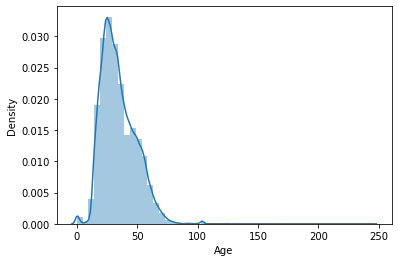

In [74]:
sns.distplot(users.Age)

In [75]:
#let's look for missing data
missing_data = pd.DataFrame([users.isnull().sum(), users.isnull().sum()*100.0/users.shape[0]]).T
missing_data.columns = ['No. of missing data ', '% missing data']
missing_data

,No. of missing data,% missing data
User-ID,0.0,0.000000
Location,0.0,0.000000
Age,110762.0,39.719857


In [76]:
# checking for all values present in age columns
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [77]:
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]

In [78]:
mean = round(required['Age'].mean())
mean

35

In [79]:

users.loc[users['Age'] > 80, 'Age'] = mean    #outliers with age grater than 80 are substituted with mean 
users.loc[users['Age'] < 10, 'Age'] = mean    #outliers with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(mean)      #filling null values with mean
users['Age'] = users['Age'].astype(int)       #changing Datatype to int
     

In [80]:
list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries 
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
users = users.drop('Location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            #handling cases where city/state entries from city list as state is already given 
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

print(count_no_country)   #printing the number of countries didnt have any values 
print(count_no_state)     #printing the states which didnt have any values
     

4659
16044


In [81]:
## Drop duplicated row
users.drop_duplicates(keep = "last", inplace = True)
users.reset_index(drop = True, inplace=True)

In [82]:
#users Dataset information
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int64 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.6+ MB


In [83]:
# checking for any duplicates values 
len(users[users.duplicated()])
# No duplicat value

0

In [84]:
# printing top 5 rows
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


#**Book-Rating Dataset Pre-processing**

In [85]:
print("columns" ,list(ratings.columns))
ratings.head()

columns ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [86]:
# chacking for null values 
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [87]:
# checking for number or not
from pandas.api.types import is_numeric_dtype
print(is_numeric_dtype(ratings['Book-Rating']))

True


In [88]:
# checking user-Id containes number or not
print(is_numeric_dtype(ratings['User-ID']))

True


In [89]:
# checking ISBN
flag  = 0
k= []
reg = "[A-Za-z0-9]"
for x in ratings['ISBN']:
  z= re.search(reg,x)
  if z:
    flag = 1
if flag == 1:
  print("false")
else:
  print("True")      


false


In [90]:

## removing extra characters from ISBN (from ratings dataset) existing in books dataset
bookISBN = books['ISBN'].tolist()
reg = "[^A-Za-z0-9]"
for index, row_value in ratings.iterrows():
  z = re.search(reg ,row_value['ISBN'])
  if z:
    f= re.sub(reg,"",row_value['ISBN'])
    if f in bookISBN:
      ratings.at[index,'ISBN'] = f

In [91]:
# uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [92]:
#drop the duplicates rows 
ratings.drop_duplicates(keep= 'last', inplace = True)
ratings.reset_index(drop = True , inplace = True)


In [93]:
##Print a concise summary of a DataFrame
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149776 non-null  int64 
 1   ISBN         1149776 non-null  object
 2   Book-Rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [94]:
# pring top 5 rows
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [95]:
# printing the shape
print(books.shape)
print(users.shape)
print(ratings.shape)

(271047, 8)
(278858, 5)
(1149776, 3)


In [96]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings.shape, ratings_new.shape

((1149776, 3), (1031472, 3))

In [97]:
print("Shape of dataset before dropping",ratings.shape)
ratings_new = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]
print("shape of dataset after dropping",ratings_new.shape)

Shape of dataset before dropping (1149776, 3)
shape of dataset after dropping (1031472, 3)


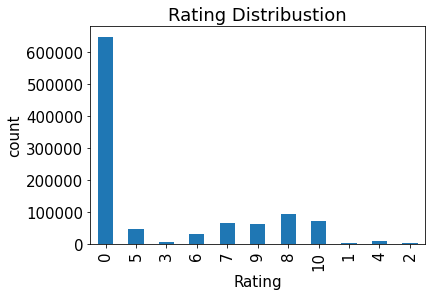

In [98]:
plt.rc("font",size = 15)
ratings_new['Book-Rating'].value_counts(sort=False).plot(kind='bar')
plt.title("Rating Distribustion")
plt.xlabel("Rating")
plt.ylabel("count")
plt.show()

In [99]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings_new['Book-Rating'] == 0]

In [100]:
print('ratings_explicit dataset shape',ratings_explicit.shape)
print('ratings_implicit dataset',ratings_implicit.shape)
     

ratings_explicit dataset shape (384024, 3)
ratings_implicit dataset (647448, 3)


<AxesSubplot:xlabel='Book-Rating', ylabel='count'>

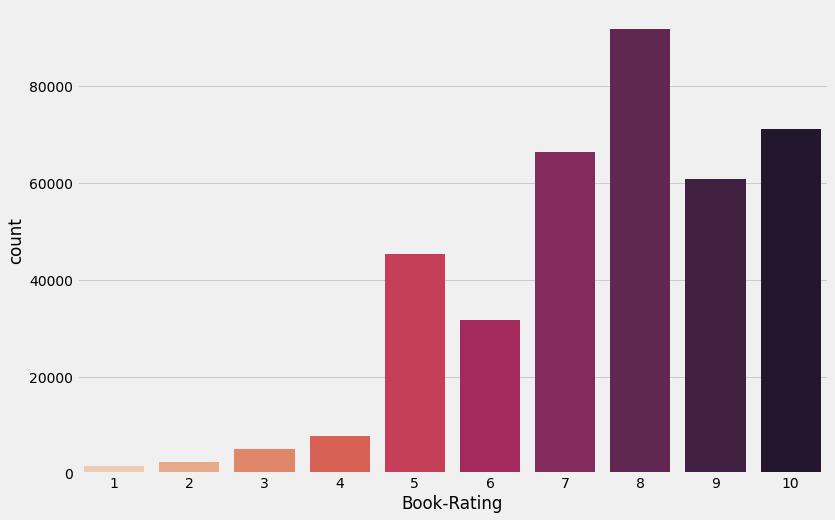

In [101]:
#plot graph b/w Book rating vs rating count 

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.countplot(data = ratings_explicit , x = 'Book-Rating', palette='rocket_r')

It can be observe that higher ratings are more common amongst users and rating 8 has been rated highest number of times

#**Merging of all three Tables**
Merging Books, Users and Rating Tables in One

In [102]:
#merging books and rating datasets using inner joint
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
#merging users with above merged datset
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
## #Print a concise summary of a DataFrame
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031609 entries, 0 to 1031608
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031609 non-null  object
 1   Book-Title           1031609 non-null  object
 2   Book-Author          1031609 non-null  object
 3   Year-Of-Publication  1031609 non-null  int64 
 4   Publisher            1031609 non-null  object
 5   Image-URL-S          1031609 non-null  object
 6   Image-URL-M          1031609 non-null  object
 7   Image-URL-L          1031605 non-null  object
 8   User-ID              1031609 non-null  int64 
 9   Book-Rating          1031609 non-null  int64 
 10  Age                  1031609 non-null  int64 
 11  City                 1031609 non-null  object
 12  State                1031609 non-null  object
 13  Country              1031609 non-null  object
dtypes: int64(4), object(10)
memory usage: 118.1+ MB


###**Divide complete data on the basis of Implicit and Explicit ratings datasets**


In [103]:
#explicit Ratings dataset
data_explicit = dataset[dataset['Book-Rating'] != 0]
data_explicit = data_explicit.reset_index(drop= True)
data_explicit.shape 

(384074, 14)

In [104]:
# implicit ratings dataset
data_implicit = dataset[dataset['Book-Rating'] == 0]
data_implicit  = data_implicit.reset_index(drop = True)
data_implicit.shape


(647535, 14)

In [105]:
# printing top 5 rows
data_explicit.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,8,5,35,timmins,ontario,canada
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/074322678X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/074322678X.01.LZZZZZZZ.jpg,8,5,35,timmins,ontario,canada
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,http://images.amazon.com/images/P/0887841740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0887841740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0887841740.01.LZZZZZZZ.jpg,8,5,35,timmins,ontario,canada
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,http://images.amazon.com/images/P/1552041778.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1552041778.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1552041778.01.LZZZZZZZ.jpg,8,5,35,timmins,ontario,canada
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,http://images.amazon.com/images/P/1567407781.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1567407781.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1567407781.01.LZZZZZZZ.jpg,8,6,35,timmins,ontario,canada


In [106]:
# print top 5 rows
data_implicit.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,City,State,Country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,2,0,18,stockton,california,usa
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,8,0,35,timmins,ontario,canada
2,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,8,0,35,timmins,ontario,canada
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg,8,0,35,timmins,ontario,canada
4,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,8,0,35,timmins,ontario,canada


##**Data Visualization**

Text(0.5, 1.0, 'No. of books by author (top 15)')

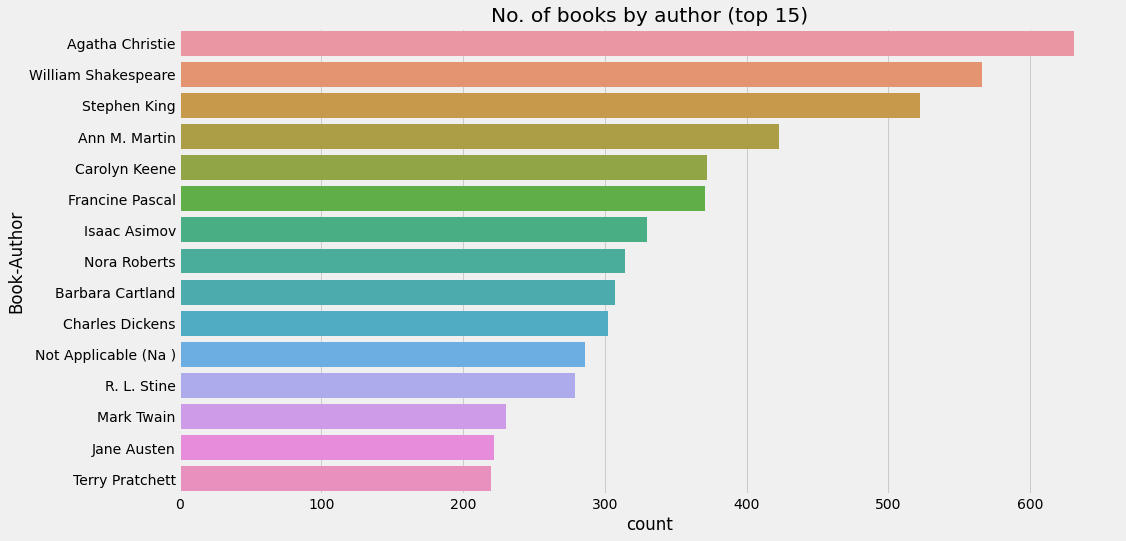

In [107]:
# top 15 book authors based on their book count
plt.figure(figsize=(15,8))
sns.countplot(y = 'Book-Author',data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("No. of books by author (top 15)")

Text(0.5, 1.0, 'No. of Books Published by Publisher (Top 15)')

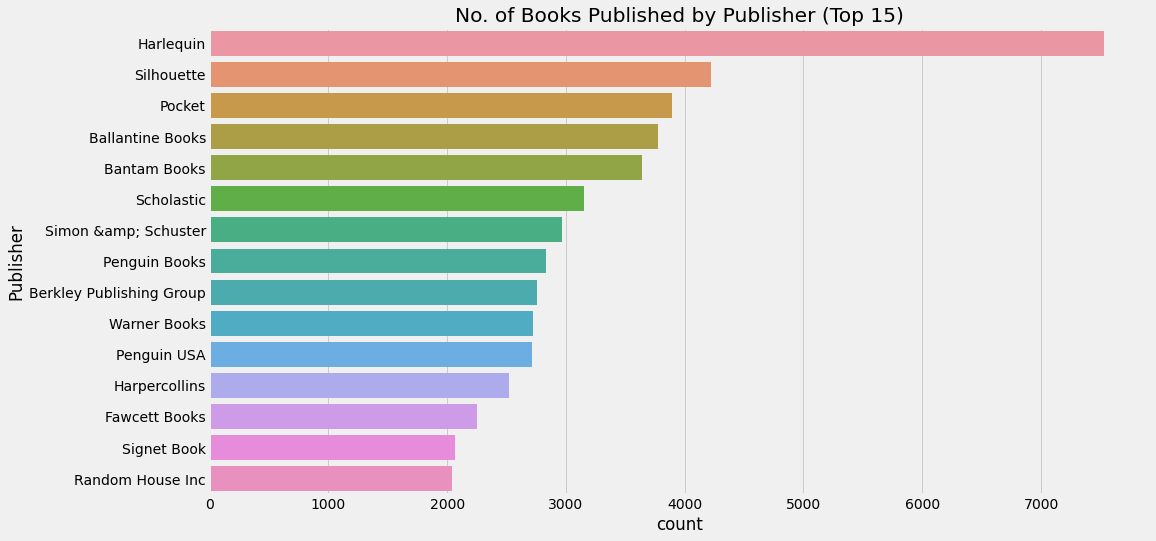

In [108]:
# top 15 Publishers based on their books Published
plt.figure(figsize=(15,8))
sns.countplot(y = "Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.title('No. of Books Published by Publisher (Top 15)')

Text(0.5, 1.0, 'explicit Ratings')

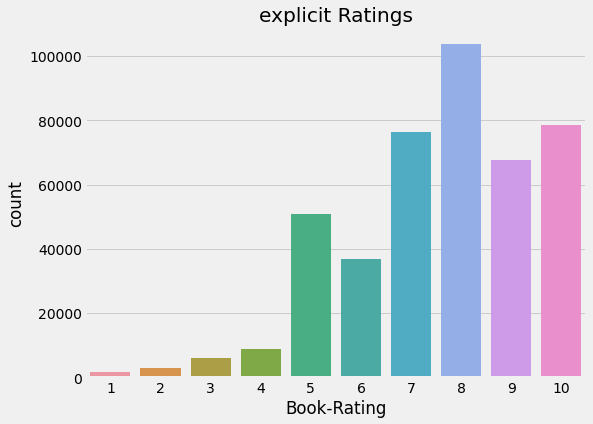

In [109]:
# Explicit ratings plot
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x = "Book-Rating", data=data)
plt.title('explicit Ratings')

Now, This countplot of rating indicates that higher ratings are more common amongst users and rating 8 has been rated highest number of times then 10 & 7. As the problem of string 'year' values was solved in the preprocessing steps, so now there's no need to convert the data types. Plotted this interactive plot to see more accurately the 'year_of _publication'(year column) distribution.

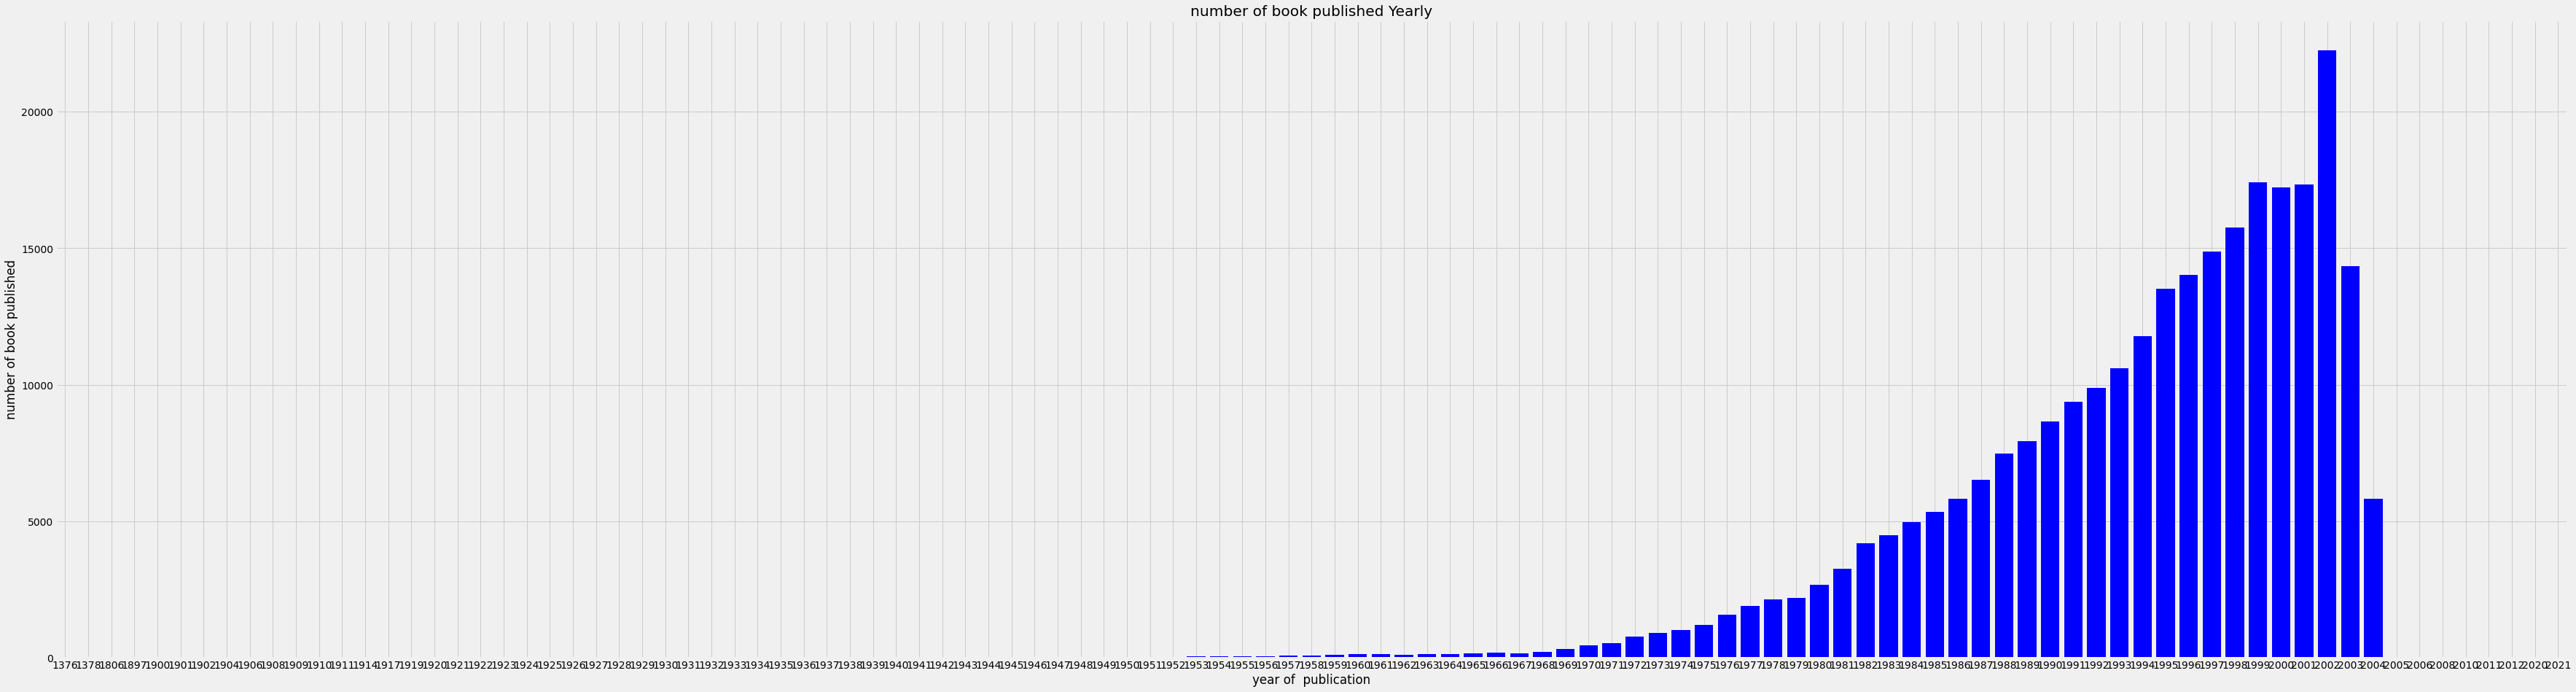

In [110]:
publications = {}
for year in books['Year-Of-Publication']:
  if str(year) not in publications:
    publications[str(year)] = 0
  publications[str(year)]  += 1

publications = {k:v for k ,v in sorted(publications.items())}
fig = plt.figure(figsize = (55,15))
plt.bar(list(publications.keys()), list(publications.values()), color = 'blue')
plt.ylabel("number of book published")     
plt.xlabel("year of  publication")     
plt.title("number of book published Yearly")
plt.margins(x = 0)
plt.show()     

So we can observe that publication years are somewhat between 1950 - 2005 here.

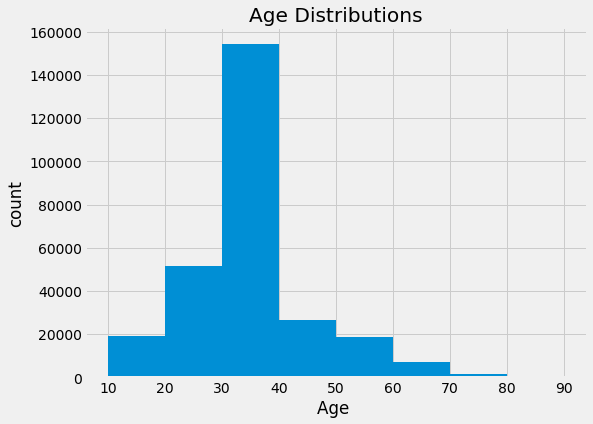

In [111]:
# Age distribution
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1,10)])
plt.title('Age Distributions')
plt.xlabel('Age ')
plt.ylabel('count')
plt.show()

We can conclude between users with age between 20-40 are highest in number

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


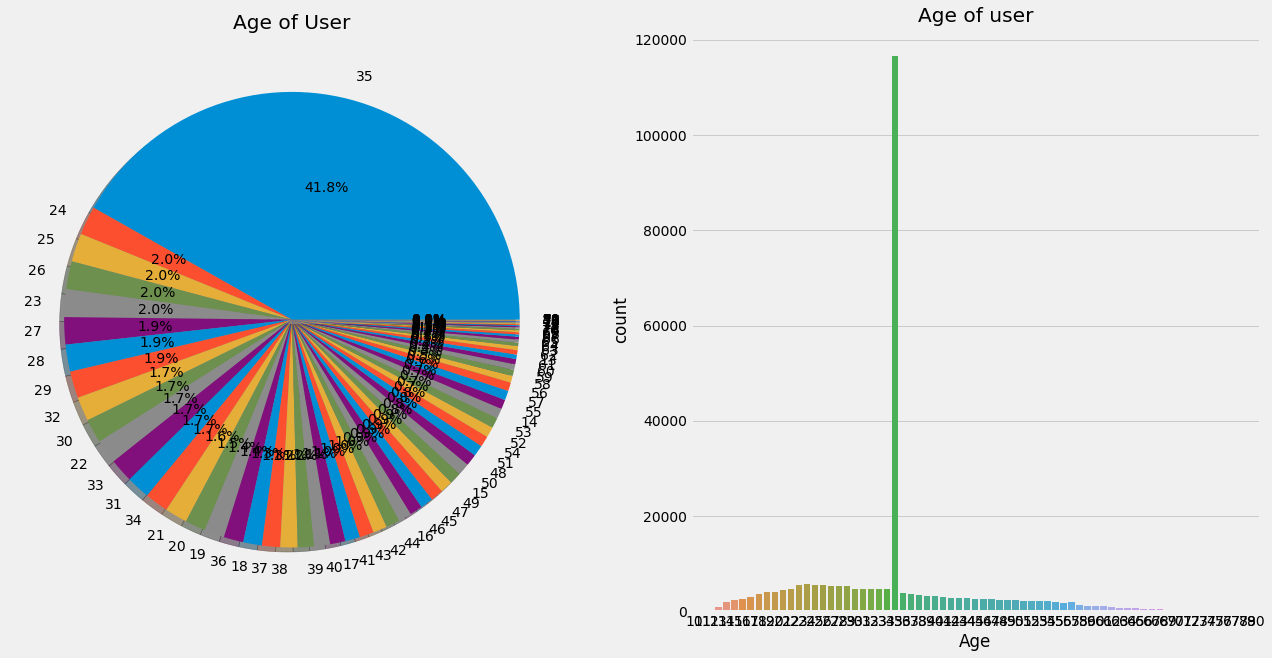

In [112]:
# ploting pie chart of age variable
f, ax =plt.subplots(1,2,figsize= (20,10)) 
users.Age.value_counts().plot.pie(autopct= '%1.1f%%', ax=ax[0],shadow=True)
ax[0].set_title('Age of User')
ax[0].set_ylabel('')

# ploting countplot of age variable
sns.countplot('Age',data=users, ax = ax[1])
ax[1].set_title('Age of user')
plt.show()

From above plots we observed that 41.9% of age 34 group read more books compared to other age groups. Also the users with the age 60 and above do not read more books.

Text(0.5, 1.0, 'No of readers from each city (Top 15)')

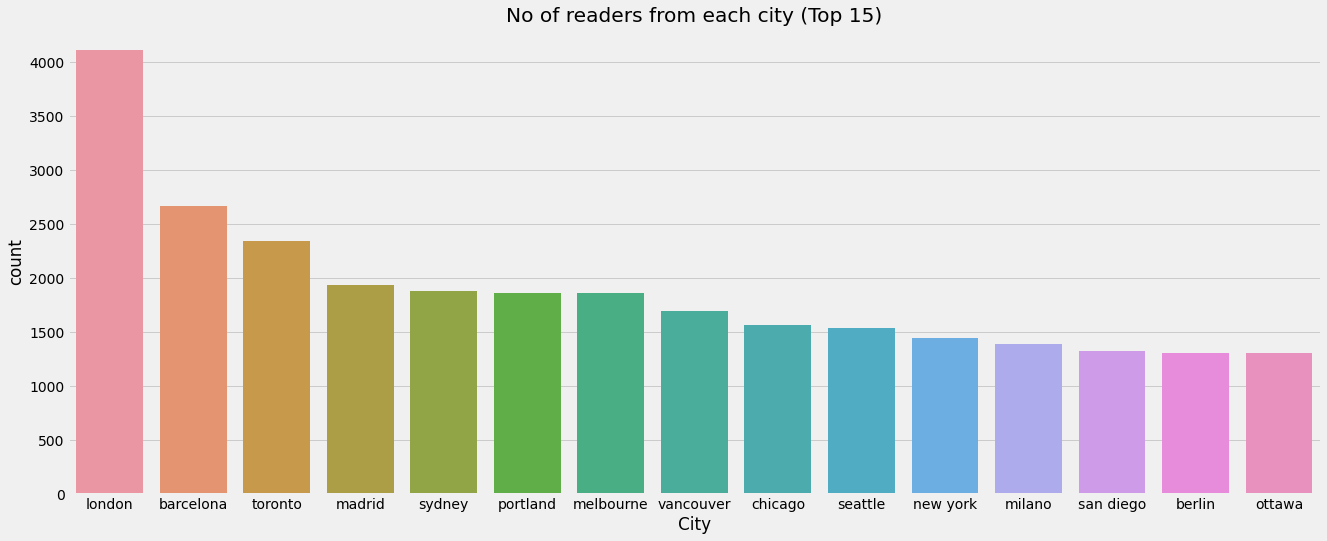

In [113]:
plt.figure(figsize=(20,8))
sns.countplot(x= "City",data= users, order= users['City'].value_counts().index[0:15])
plt.title("No of readers from each city (Top 15)")


Here we can see that user with locations London,barcelona,toronto,madrid,sydney,ontario,melbourne are high in numbers.

Text(0.5, 1.0, 'No of readers from each state (Top 15)')

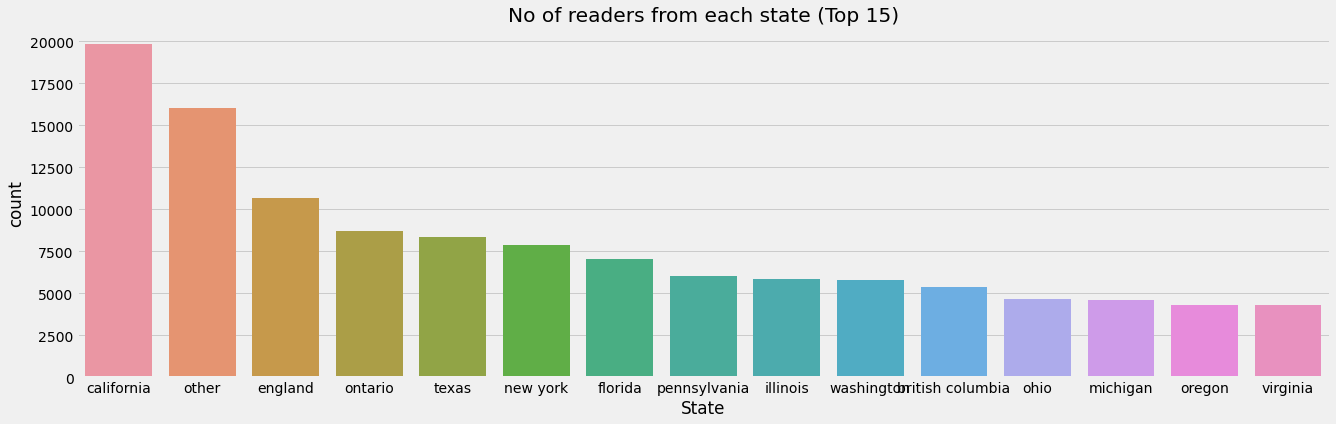

In [114]:
#top 15 States based on user count
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:15])
plt.title("No of readers from each state (Top 15)")

Text(0.5, 1.0, 'No. of readers from each country (Top 10)')

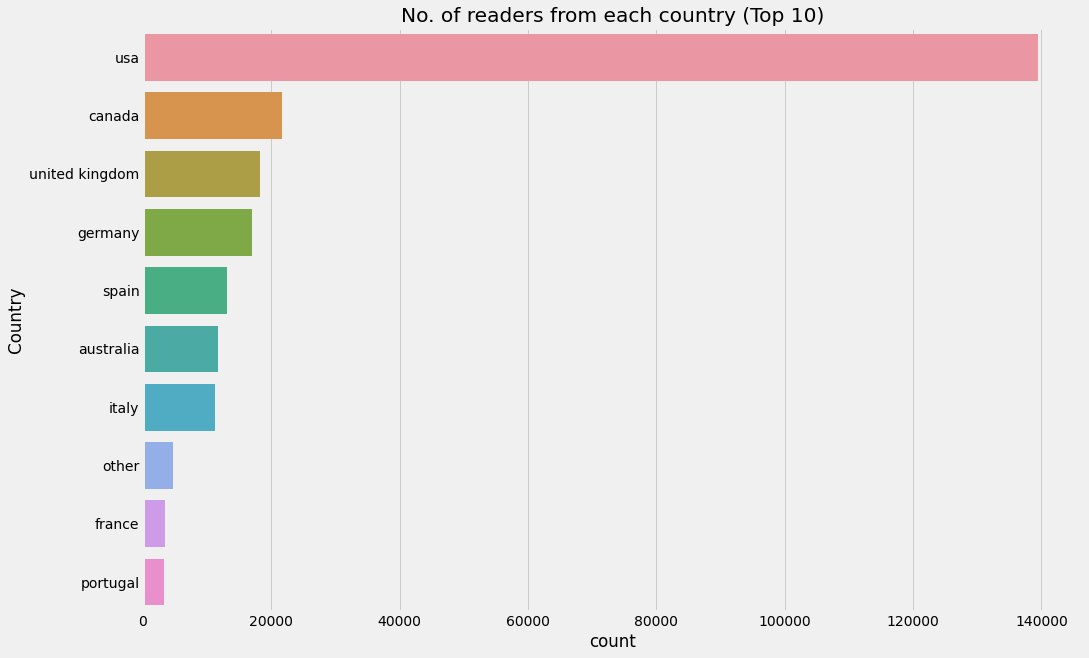

In [115]:
# Top 10 countries based on number of readers
plt.figure(figsize=(15,10))
sns.countplot(y="Country" , data = users, order = users['Country'].value_counts().index[0:10])
plt.title("No. of readers from each country (Top 10)")

Text(0.5, 1.0, 'No of readers from states of USA (Top 15)')

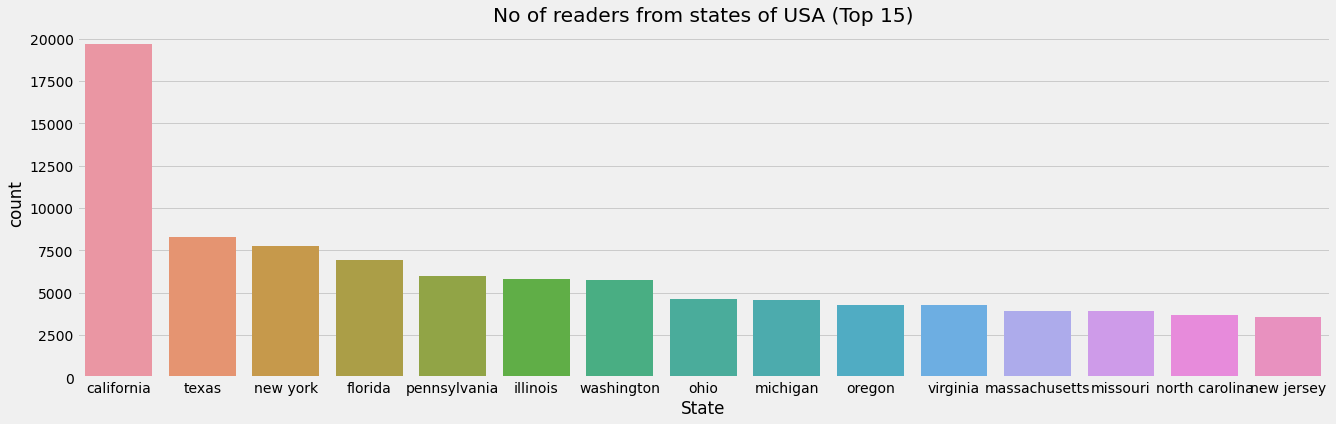

In [116]:
#Top 15 readers from states of USA
data = users[users['Country'] == 'usa']
plt.figure(figsize=(20,6))
sns.countplot(x= 'State', data = data , order =data['State'].value_counts().index[0:15])
plt.title("No of readers from states of USA (Top 15)")

Text(0.5, 1.0, 'Number of Ratings for a book (Top 20)')

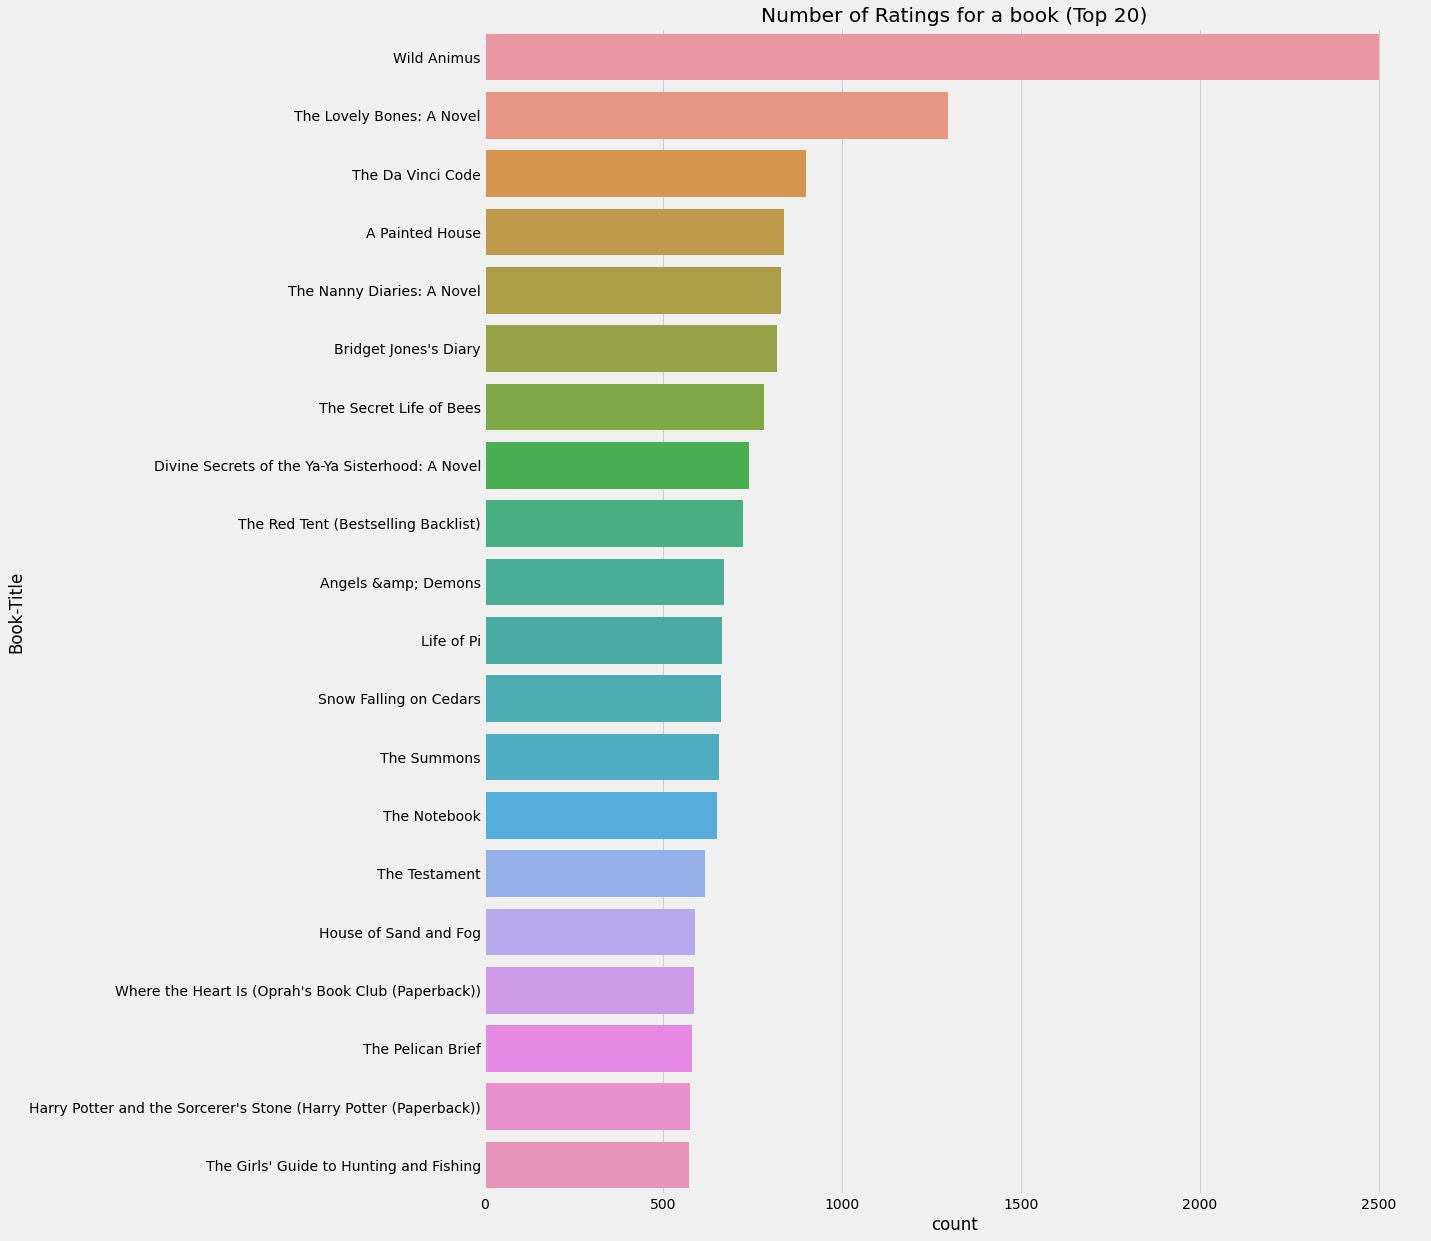

In [117]:

#polt the bar plot book title vs Rating count
plt.figure(figsize=(15,20))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:20])
plt.title("Number of Ratings for a book (Top 20)")

#**Popularity based Recommendation System**

In [118]:
ratings_with_name = ratings.merge(books, on = 'ISBN')

In [119]:
num_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns = {'Book-Rating' : 'num_ratings'}, inplace = True)
num_rating_df

,Book-Title,num_ratings
0,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, Book 5)",1
4,Beyond IBM: Leadership Marketing and Finance for the 1990s,1
...,...,...
241068,Ã?Â?lpiraten.,2
241069,Ã?Â?rger mit Produkt X. Roman.,4
241070,Ã?Â?sterlich leben.,1
241071,Ã?Â?stlich der Berge.,3


In [120]:
avg_rating_df = ratings_with_name.groupby('Book-Title').mean()['Book-Rating'].reset_index()
avg_rating_df.rename(columns = {'Book-Rating' : 'avg_ratings'}, inplace = True)
avg_rating_df

,Book-Title,avg_ratings
0,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",2.250000
1,Always Have Popsicles,0.000000
2,Apple Magic (The Collector's series),0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, Book 5)",8.000000
4,Beyond IBM: Leadership Marketing and Finance for the 1990s,0.000000
...,...,...
241068,Ã?Â?lpiraten.,0.000000
241069,Ã?Â?rger mit Produkt X. Roman.,5.250000
241070,Ã?Â?sterlich leben.,7.000000
241071,Ã?Â?stlich der Berge.,2.666667


In [143]:
popular_df = num_rating_df.merge(avg_rating_df,on = 'Book-Title')


In [146]:
popular_df = popular_df[popular_df['num_ratings'] >= 250].sort_values('avg_ratings',ascending = False).head(50)
popular_df .head()

,Book-Title,Book-Author,Image-URL-M,num_ratings,avg_ratings
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,http://images.amazon.com/images/P/0439136350.01.MZZZZZZZ.jpg,428,5.852804
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,http://images.amazon.com/images/P/0439139597.01.MZZZZZZZ.jpg,387,5.824289
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,http://images.amazon.com/images/P/0590353403.01.MZZZZZZZ.jpg,278,5.737410
8,Harry Potter and the Order of the Phoenix (Book 5),J. K. Rowling,http://images.amazon.com/images/P/0439567610.01.MZZZZZZZ.jpg,347,5.501441
11,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,http://images.amazon.com/images/P/0439064872.01.MZZZZZZZ.jpg,556,5.183453


In [145]:
popular_df = popular_df.merge(books, on = 'Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author','Image-URL-M','num_ratings','avg_ratings']]
popular_df.head()

,Book-Title,Book-Author,Image-URL-M,num_ratings,avg_ratings
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,http://images.amazon.com/images/P/0439136350.01.MZZZZZZZ.jpg,428,5.852804
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,http://images.amazon.com/images/P/0439139597.01.MZZZZZZZ.jpg,387,5.824289
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,http://images.amazon.com/images/P/0590353403.01.MZZZZZZZ.jpg,278,5.737410
8,Harry Potter and the Order of the Phoenix (Book 5),J. K. Rowling,http://images.amazon.com/images/P/0439567610.01.MZZZZZZZ.jpg,347,5.501441
11,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,http://images.amazon.com/images/P/0439064872.01.MZZZZZZZ.jpg,556,5.183453


In [124]:
popular_df['avg_ratings' ][0]

5.852803738317757

#**collaborative Filtering based recommendation system**

In [125]:
x = ratings_with_name.groupby('User-ID').count()['Book-Rating'] >= 200
most_rating_user = x[x].index

In [147]:
filtered_ratings = ratings_with_name[ratings_with_name['User-ID'].isin(most_rating_user)]
filtered_ratings.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.LZZZZZZZ.jpg
5,23768,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.LZZZZZZZ.jpg
7,28523,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.LZZZZZZZ.jpg
15,77940,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.LZZZZZZZ.jpg
16,81977,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.LZZZZZZZ.jpg


In [127]:
y = filtered_ratings.groupby('Book-Title').count()['Book-Rating'] >= 50
most_rating_books = y[y].index
most_rating_books

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Day Late and a Dollar Short', 'A Fine Balance',
       ...
       'Winter Solstice', 'Wish You Well', 'Without Remorse',
       'Wizard and Glass (The Dark Tower, Book 4)', 'Wuthering Heights',
       'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       'Zoya', '\O\" Is for Outlaw"'],
      dtype='object', name='Book-Title', length=708)

In [128]:
final_ratings = filtered_ratings[filtered_ratings['Book-Title'].isin(most_rating_books)]
final_ratings

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
63,278418,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.LZZZZZZZ.jpg
65,3363,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.LZZZZZZZ.jpg
66,7158,0446520802,10,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.LZZZZZZZ.jpg
69,11676,0446520802,10,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.LZZZZZZZ.jpg
74,23768,0446520802,6,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.LZZZZZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...
1027207,266865,0531001725,10,The Catcher in the Rye,Jerome David Salinger,1973,Scholastic Library Pub,http://images.amazon.com/images/P/0531001725.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0531001725.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0531001725.01.LZZZZZZZ.jpg
1028403,269566,0670809381,0,Echoes,Maeve Binchy,1986,Penguin USA,http://images.amazon.com/images/P/0670809381.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0670809381.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0670809381.01.LZZZZZZZ.jpg
1029257,271284,0440910927,0,The Rainmaker,John Grisham,1995,Island,http://images.amazon.com/images/P/0440910927.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440910927.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440910927.01.LZZZZZZZ.jpg
1029550,271705,B0001PIOX4,0,Fahrenheit 451,Ray Bradbury,1993,Simon &amp; Schuster,http://images.amazon.com/images/P/B0001PIOX4.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/B0001PIOX4.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/B0001PIOX4.01.LZZZZZZZ.jpg


In [129]:
pt =final_ratings.pivot_table(index= 'Book-Title', columns = 'User-ID',values = "Book-Rating")

In [130]:
pt.fillna(0, inplace = True)

In [131]:
pt

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:

from sklearn.metrics.pairwise import cosine_similarity


In [133]:
similarity_score = cosine_similarity(pt)

In [134]:
similarity_score.shape


(708, 708)

In [135]:
def recommend(book_name):
  index = np.where(pt.index == book_name)[0][0]
  similar_items = sorted(list(enumerate(similarity_score[index])),key = lambda x:x[1],reverse =True)[1:5]
  data = []
  for i in similar_items:
    item =[]
    temp_df = books[books['Book-Title'] == pt.index[i[0]]]
    item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
    item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
    item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
    data.append(item)
  return data                    
                    

In [148]:
recommend('1984')

[['Animal Farm',
  'George Orwell',
  'http://images.amazon.com/images/P/0451526341.01.MZZZZZZZ.jpg'],
 ["The Handmaid's Tale",
  'Margaret Atwood',
  'http://images.amazon.com/images/P/0449212602.01.MZZZZZZZ.jpg'],
 ['Brave New World',
  'Aldous Huxley',
  'http://images.amazon.com/images/P/0060809833.01.MZZZZZZZ.jpg'],
 ['The Vampire Lestat (Vampire Chronicles, Book II)',
  'ANNE RICE',
  'http://images.amazon.com/images/P/0345313860.01.MZZZZZZZ.jpg']]

In [137]:
pt.index[545]

'The Guardian'

In [138]:
import pickle
pickle.dump(popular_df,open('popular.pk1','wb'))

In [139]:
pickle.dump(pt,open('pt.pk1','wb'))
pickle.dump(books,open('books.pk1','wb'))
pickle.dump(similarity_score,open('similarity_score.pk1','wb'))